In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4
from erddapy import ERDDAP
import json

Configure the ERDDAP to search

In [2]:
ra = 'cencoos'

with open('utils/ra_erddaps.json') as f:
    urls = json.load(f)

server = urls[ra.lower()]

print(server)

e = ERDDAP(server=server, protocol="tabledap")

http://erddap.cencoos.org/erddap


Pull in the processed inventory

In [3]:
#
# df_cruise = df[df['Station Description'] == 'Chesapeake Bay WQ Cruise Data ']
#
#df_aws = df[df['Station ID'] == 'Humboldt']
# #url = 'http://tds.glos.us/thredds/dodsC/buoy_agg_standard/OMOECC_E1/OMOECC_E1.ncml'
# #url = 'http://tds.glos.us/thredds/dodsC/buoy_agg_standard/45186/45186.ncml'
# #url = 'http://tds.glos.us/thredds/dodsC/buoy_agg_standard/bgsusd2/bgsusd2.ncml'
# url = 'http://oos.soest.hawaii.edu/thredds/dodsC/hioos/nss/ns12agg'
# print(url)
# ds = xr.open_dataset(url)
# #ds = netCDF4.Dataset(url,'r')
# title = ds.title
# start_time = np.datetime_as_string(ds.time.min().values, unit='D')
# end_time = np.datetime_as_string(ds.time.max().values, unit='D')
# print('Duration: %s - %s' % (np.datetime_as_string(ds.time.min().values, unit='D'),
#                              np.datetime_as_string(ds.time.max().values, unit='D'))
#       )

# Try glos web server
# url = 'https://glbuoys.glos.us/tools/export?ftype=csv&data_type=buoy&units=eng&locs=OMOECC_E1&params=Water_Temperature_at_Surface|dissolved_oxygen_saturation|water_conductivity|ysi_turbidity&tperiod=custom&date_start=2020-01-01&date_end=2020-12-31&avg_ivld=none'
# df = erddapy.ERDDAP.to_pandas(url)

## using ERDDAP to look for stations
# check out http://data.glos.us/erddap/tabledap/allDatasets.htmlTable?datasetID%2Ctitle%2CminTime%2CmaxTime&maxTime%3E=2020-01-01&maxTime%3C=2020-12-31&orderBy(%22maxTime%22)
# that lists out all the GLOS stations with the maximum time of observations within the year 2020 (on their ERDDAP).

df = pd.read_excel('2021/data/processed/%s.xlsx' % ra.upper(), dtype=str)
df

,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude (dec deg),Longitude (dec deg),Platform Type,"Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)","Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,"Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].",Additional notes
0,Trinidad,TDPC1,Trinidad Pier,Trinidad Shore Station,41.06,-124.15,fixed pier,2008-12-31 00:00:00,y,HSU/CeNCOOS,Yp,HSU,Academic,HSU,CeNCOOS/HSU,"sea_water_temperature(4.6m), sea_water_salinit...",Need to check variables
1,Humboldt,HBXC1,Humboldt Bay: Chevron Dock,Chevron Dock Pier Station,40.78,-124.2,fixed pier,2003,y,HSU/CeNCOOS,yp,HSU,Academic,HSU,CeNCOOS/HSU,"sea_water_temperature(2m), sea_water_salinity(...",NaN
2,Bodega,BDXC1,Bodega BDXC1,Horeshoe cove BML Seawater Intake Station,38.32,-123.07,fixed intake,2003,y,UC Davis/CeNCOOS,yp,UC Davis (BML),Academic,UC Davis (BML),BML,"sea_water_temperature(2.9m), sea_water_salinit...",NaN
3,Tomales Bay,NaN,Tomales Bay,Tomales Bay Buoy,38.19,-122.93,moored buoy,2013-06-03 00:00:00,y,UC Davis/CeNCOOS,n,UC Davis (BML),Academic,UC Davis (BML),BML,"sea_water_temperature, sea_water_salinity, mas...",NaN
4,Hog Island,NaN,Hog Island,Hog Island Hatchery,36.162,-122.8939,fixed intake,2014-05-31 00:00:00,y,UC Davis/CeNCOOS,Yp,UC Davis,Academic,UC Davis,UC Davis,"sea_water_temperature(3.03m), sea_water_salini...",NaN
5,Carquinez,CQU1,Carquinez,Carquinez at Cal Maritime,38.07,-122.23,fixed pier,2008-02-21 00:00:00,y,SFSU/CeNCOOS,Yp,SFSU,Academic,SFSU,SFSU,"sea_water_temperature(2.7m), sea_water_salini...",NaN
6,Tiburon,TIBC1,Tiburon,Tiburon Pier,37.89,-122.45,fixed pier,2002-11-01 00:00:00,y,SFSU/CeNCOOS,Yp,SFSU,Academic,SFSU,SFSU,"sea_water_temperature(1.9m), sea_water_salinit...",NaN
7,Fort Point,FPXC1,Fort Point,Fort Point,37.81,-122.47,fixed pier,2009-02-28 00:00:00,y,UC Davis/CeNCOOS,Yp,UC Davis (BML),Academic,UC Davis (BML),BML,"sea_water_temperature(3.5m), sea_water_salinit...",NaN
8,Exploratorium,NaN,Exploritorium,Exploritorium,37.8,-122.397,fixed pier,NaN,NaN,Exploratorium,N,Exploratorium,nonprofit,Exploratorium,Exploratorium,"sea_water_temperature, sea_water_salinity, sea...",NaN
9,IFCB San Francisco Pier 17,NaN,San Francisco Pier 17 IFCB,San Francisco Pier 17 IFCB,37.8,-122.397,fixed pier,2016-09-01 00:00:00,o,UCSC,N,UCSC,Academic,UCSC,UCSC,NaN,NaN


Search the ERDDAP server for a single station of interest - more of a test

In [4]:
# df['Station ID'].loc[df['Station ID'].isna()] = df.loc[df['Station ID'].isna(),'Dataset ID']

# df['Station ID']

In [5]:
df_wf = df[df['Station ID'] == 'ioos:station:TCOON:076']

# for SCCOOS need to search for 'Station Long Name' as 'Station ID' is NA for most entries
search_for = df_wf['Station ID'].to_string()

search_url = e.get_search_url(search_for=search_for, response="csv")

try:
    resp = pd.read_csv(search_url)
    print(resp['Station ID'])
except:
    pass

Rip through all the datasets in the inventory and see if they exist on the RA erddap. Process checks the following order:

1. `Station ID`, then 
2. `Station Long Name`, then
3. `WMO ID or NWS/CMAN ID`

We first check if the value is `nan`. If so, we punt as that will return all datasets from the ERDDAP service.

In [6]:
not_found = []
found = dict()

exclude = ' -gliders'

for station in df['Station Long Name'].astype(str):
    
    if station == "nan":
        print("punting with station long name = nan\n")
        not_found.append(station)
        continue
    
    try:
        search_url = e.get_search_url(search_for=station+exclude, response="csv")
        resp = pd.read_csv(search_url)
        print("Found \"%s\": %s" % (station,resp['Dataset ID'].values.tolist()))
        
        found[station] = {'Dataset ID': resp['Dataset ID'].values.tolist()}
        
    except:
        
        #not_found.append(station)
#        pass
        print('no dataset matching \"%s\"' % station)
        station_long_name = df.loc[df['Station Long Name'] == station,'WMO ID or NWS/CMAN ID'].values.tolist()[0]
        
        if station_long_name == "nan":
                print("punting with WMO id = nan\n")
                not_found.append(station)
                continue
                
        try:
            print('searching \"wmo ID\" = \"%s\"' % station_long_name)
            search_url = e.get_search_url(search_for=station_long_name+exclude, response="csv")
            resp = pd.read_csv(search_url)
            print("Found \"%s\": %s" % (station_long_name,resp['Dataset ID'].values.tolist()))
            
            found[station] = {'Dataset ID': resp['Dataset ID'].values.tolist()}
            
        except:

            station_wmo = str(df.loc[df['Station Long Name'] == station,'Station ID'].values.tolist()[0])
            
            if station_wmo == "nan":
                print("punting with station ID = nan\n")
                not_found.append(station)
                continue
            
            try:
                print('searching \"station ID\" = \"%s\"' % station_wmo)
                search_url = e.get_search_url(search_for=station_wmo+exclude, response="csv")
                resp = pd.read_csv(search_url)
                print("Found \"%s\": %s" % (station_wmo,resp['Dataset ID'].values.tolist()))
                
                found[station] = {'Dataset ID': resp['Dataset ID'].values.tolist()}
                
            except:    
                not_found.append(station)
        
    print("\n")

Found "Trinidad Pier": ['edu_humboldt_tdp']


no dataset matching "Humboldt Bay: Chevron Dock"
searching "wmo ID" = "HBXC1"
Found "HBXC1": ['edu_humboldt_humboldt']


Found "Bodega BDXC1": ['bodega-bay-bml_wts']


Found "Tomales Bay": ['tomales-bay-buoy', 'edu_ucdavis_bml_hog_island_oyster']


Found "Hog Island": ['hog-island-hatchery', 'edu_ucdavis_bml_hog_island_oyster']


Found "Carquinez": ['gov_usgs_waterdata_11455820', 'carquinez']


Found "Tiburon": ['tiburon-co2', 'miscwebcam_122', 'edu_utah_mesowest_au915', 'tiburon-water-tibc1', 'tiburon-weather-tibc1', 'carquinez']


Found "Fort Point": ['fort-point', 'nps_fo3']


no dataset matching "Exploritorium"
searching "wmo ID" = "nan"
searching "station ID" = "Exploratorium"
Found "Exploratorium": ['exploratorium-seabird', 'exploratorium-turner', 'exploratorium-weather', 'exploratorium-pco2-buoy', 'gov_usgs_waterdata_374811122235001']


no dataset matching "San Francisco Pier 17 IFCB"
searching "wmo ID" = "nan"
searching "station ID"

Print the stations that we couldn't find.

In [7]:
len(not_found)

2

In [8]:
len(found)

16

In [9]:
df.loc[df['Station Long Name'].isna()]

,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude (dec deg),Longitude (dec deg),Platform Type,"Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)","Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,"Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].",Additional notes


In [10]:
df[df['Station Long Name'].isin(not_found)]

,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude (dec deg),Longitude (dec deg),Platform Type,"Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)","Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,"Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].",Additional notes
9,IFCB San Francisco Pier 17,NaN,San Francisco Pier 17 IFCB,San Francisco Pier 17 IFCB,37.8,-122.397,fixed pier,2016-09-01 00:00:00,o,UCSC,N,UCSC,Academic,UCSC,UCSC,NaN,NaN
11,IFCB Santa Cruz,NaN,Santa Cruz Municipal Wharf IFCB,Santa Cruz Municipal Wharf IFCB,36.96,-122.02,fixed pier,2015-08-01 00:00:00,y,UCSC,N,UCSC,Academic,UCSC,UCSC,NaN,NaN


In [11]:
#found.pop('HTLPWES')
found

{'Trinidad Pier': {'Dataset ID': ['edu_humboldt_tdp']},
 'Humboldt Bay: Chevron Dock': {'Dataset ID': ['edu_humboldt_humboldt']},
 'Bodega BDXC1': {'Dataset ID': ['bodega-bay-bml_wts']},
 'Tomales Bay': {'Dataset ID': ['tomales-bay-buoy',
   'edu_ucdavis_bml_hog_island_oyster']},
 'Hog Island': {'Dataset ID': ['hog-island-hatchery',
   'edu_ucdavis_bml_hog_island_oyster']},
 'Carquinez': {'Dataset ID': ['gov_usgs_waterdata_11455820', 'carquinez']},
 'Tiburon': {'Dataset ID': ['tiburon-co2',
   'miscwebcam_122',
   'edu_utah_mesowest_au915',
   'tiburon-water-tibc1',
   'tiburon-weather-tibc1',
   'carquinez']},
 'Fort Point': {'Dataset ID': ['fort-point', 'nps_fo3']},
 'Exploritorium': {'Dataset ID': ['exploratorium-seabird',
   'exploratorium-turner',
   'exploratorium-weather',
   'exploratorium-pco2-buoy',
   'gov_usgs_waterdata_374811122235001']},
 'Santa Cruz Wharf': {'Dataset ID': ['santa-cruz-wharf-weather-stat',
   'edu_ucsc_scwharf1']},
 'Moss Landing': {'Dataset ID': ['mlml_m

Check if the dataset has coverage for CY 2021

In [12]:
valid_datasets = []

for key in found:
    
    dataset_id = found[key]['Dataset ID']
    
    if len(dataset_id)>1:
        
        for dataset in dataset_id:
            
            e.dataset_id = dataset
    
            e.constraints = {
                 "time>=": "2021-01-01"
            }
        
            e.variables = ['time']
    
            try:
                df_data = e.to_pandas(parse_dates=True)
                valid_datasets.extend([key])
                
            except:
                pass

                #print("No data for 2021 for %s: dataset ID %s" % (key,e.dataset_id))

    else:
        
        e.dataset_id = dataset_id[0]
    
        e.constraints = {
                         "time>=": "2021-01-01"
                        }
        
        e.variables = ['time']
        
        try:
            
            df_data = e.to_pandas(parse_dates=True)

            valid_datasets.extend([key])

        except:
            pass

            #print("No data for 2021 for %s: dataset ID %s" % (key,e.dataset_id))

            
#for valid in sorted(set(valid_datasets)):
    
#     # drop qc vars
#     cols = [c for c in df_data.columns if 'qc' not in c]
#     cols = [c for c in cols if 'QARTOD' not in c]

#     df_data = df_data[cols]

#     # set index for plotting
#     df_data = df_data.set_index(df_data['time (UTC)'])

#     # plot
#     #df_data.plot(subplots=True, title=e.dataset_id,figsize=(20,20))

#     start_time = df_data['time (UTC)'].min()
#     end_time = df_data['time (UTC)'].max()

#     print('Dataset %s' % e.dataset_id)
#     print('Duration: %s - %s' % (start_time, end_time))

non_2021_datasets = found.keys() - sorted(set(valid_datasets))

print('Datasets without coverage for 2021:\n%s' % non_2021_datasets)

Datasets without coverage for 2021:
set()


Show me the inventory metadata about the invalid stations:

In [23]:
bad_stations = df.loc[(df['Station Long Name'].isin(non_2021_datasets)) | df['Station Long Name'].isin(not_found)]

df['erddap_not_avail'] = df['Station Long Name'].isin(bad_stations['Station Long Name'])

In [24]:
df['erddap_not_avail']

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9      True
10    False
11     True
12    False
13    False
14    False
15    False
16    False
17    False
Name: erddap_not_avail, dtype: bool

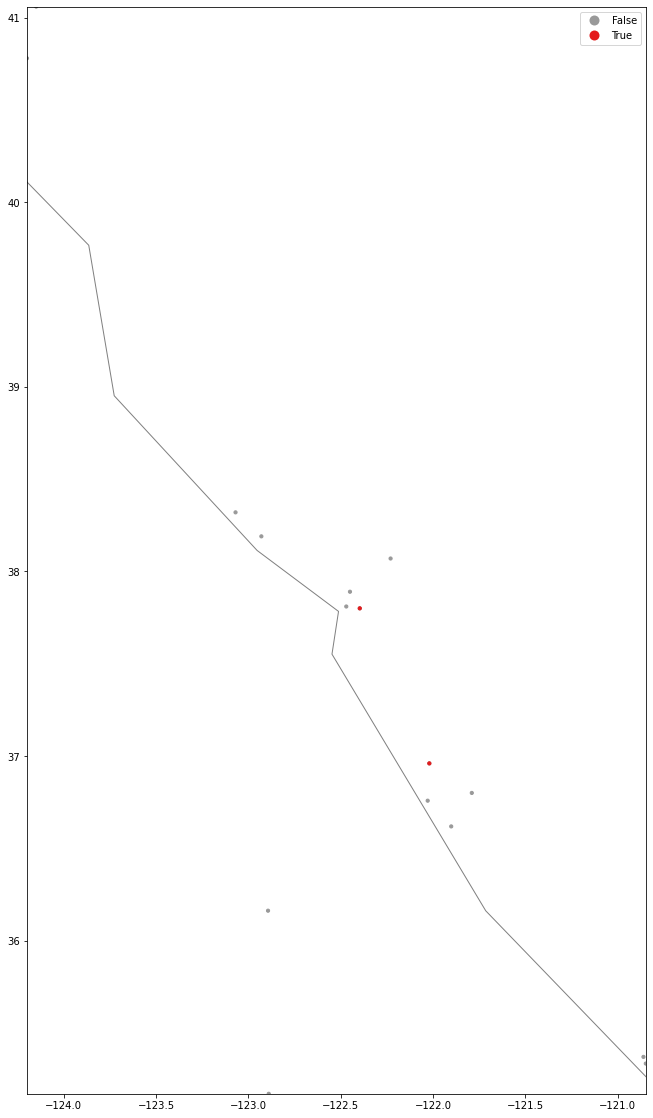

In [25]:
import geopandas
import matplotlib.pyplot as plt

#df = df.loc[df['']]

df.rename(columns=
{'Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].':
     'Variable Names',
 'Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)': 'Station Deployment',
 'Longitude (dec deg)': 'Longitude',
 'Latitude (dec deg)': 'Latitude'},
              inplace=True)

df['Station Deployment'] = \
    df['Station Deployment'].astype(str)


gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df['Longitude'], df['Latitude']))

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

ax = world.plot(
    color='white', 
    edgecolor='grey', 
    figsize=(25,20),
    )

gdf.plot( ax=ax,
         column='erddap_not_avail', 
         categorical=True, 
         cmap = 'Set1_r',
         markersize=10, 
         legend=True,
         k=2,
        )



minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

plt.show()

In [26]:
gdf_final = gdf.set_crs(epsg=4326)

gdf_final.explore('erddap_not_avail',cmap = 'Set1_r',)

In [17]:
gdf_final.loc[gdf_final['geometry'].is_empty == True]

,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude,Longitude,Platform Type,Station Deployment,"Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,Variable Names,Additional notes,erddap_not_avail,geometry


In [18]:
# import urllib.request
# for url in gdf_final.loc[gdf_final['erddap_not_avail'],'Station Description'].str.replace('url: ',''):
#     print(url)
#     try:
#         urllib.request.urlopen(url).getcode()
#     except:
#         print("URL broken: %s" % url)
#         print(gdf_final.loc[gdf_final['Station Description'].str.contains(url,regex=False),'Station ID'])

In [19]:
df.shape

(18, 19)

In [22]:
gdf_final['Station Description'].astype(str)

0                        Trinidad Shore Station
1                     Chevron Dock Pier Station
2     Horeshoe cove BML Seawater Intake Station
3                              Tomales Bay Buoy
4                           Hog Island Hatchery
5                     Carquinez at Cal Maritime
6                                  Tiburon Pier
7                                    Fort Point
8                                 Exploritorium
9                    San Francisco Pier 17 IFCB
10                             Santa Cruz Wharf
11              Santa Cruz Municipal Wharf IFCB
12                 Moss Landing Seawater Intake
13                                           M1
14        Monterey Bay Aquarium Seawater Intake
15                            Morro Bay: T-Pier
16                           Morro Back Bay BS1
17                  San Luis Bay: Cal Poly Pier
Name: Station Description, dtype: object